In [37]:
from sentence_transformers import (
    SentenceTransformer,
    InputExample,
    losses,
    SentenceTransformerTrainingArguments,
    SentenceTransformerTrainer,
)

from sentence_transformers.evaluation import (
    BinaryClassificationEvaluator,
    SimilarityFunction,
)

from transformers import AutoConfig, AutoTokenizer, AutoModel

from torch import nn
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import paired_cosine_distances
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

os.environ["NCCL_P2P_DISABLE"] = "1"
os.environ["NCCL_IB_DISABLE"] = "1"

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [38]:
model_id = "bge-base/checkpoint-600"

model = SentenceTransformer(model_id)

In [39]:
dataset = load_dataset("csv", data_files="data/test.csv")

In [41]:
dataset = dataset.remove_columns('id')
dataset = dataset.rename_column('question1', 'text1')
dataset = dataset.rename_column('question2', 'text2')

In [42]:
test_dataset = dataset['train']

## Test model

In [43]:
# trainer.state.best_model_checkpoint
# model = SentenceTransformer(trainer.state.best_model_checkpoint)

In [44]:
def test_model(model, test_dataset, clip_negative=True):
    sentences1=test_dataset['text1']
    sentences2=test_dataset["text2"]

    sentences = sentences1 + sentences2
    embeddings = model.encode(
        sentences,
        normalize_embeddings=True,
        show_progress_bar=True,
        convert_to_numpy=True,
    )
    
    embeddings1 = embeddings[: len(sentences1)]
    embeddings2 = embeddings[len(sentences1) :]

    similarity = 1 - paired_cosine_distances(embeddings1, embeddings2)
    if clip_negative:
        similarity[similarity < 0] = 0.0
    return similarity

In [45]:
similarity = test_model(model, test_dataset)

Batches:   0%|          | 0/3344 [00:00<?, ?it/s]

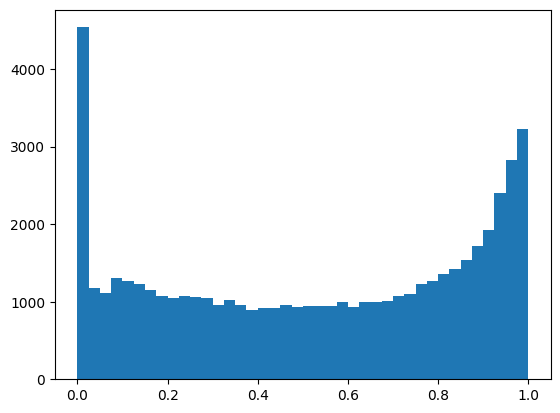

In [46]:
plt.hist(similarity, bins=40)
plt.show()

In [53]:
df_sub = pd.read_csv('data/submission.csv')

In [54]:
df_sub.head()

,id,pred
0,0,0.075591
1,1,0.681036
2,2,0.970905
3,3,0.995534
4,4,0.173098


In [55]:
df_sub['pred'] = similarity

In [56]:
# df_sub.drop('Unnamed: 0', axis=1)

In [57]:
df_sub.to_csv('data/submission.csv', index=False)